<a href="https://colab.research.google.com/github/VintageGold/Outages_Prediction/blob/master/Scenario_Time_Series_Forecasting_Outage_Weather_and_Usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook is Modeled after the TensorFlow tutorial below.  The Majority of comments are from the notebook to keep readability between the two documents, and the documentation explains the steps clearly and concisely.



# Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#### Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

# This notebook will explore whether Outage, Usage data from PJM and Weather data can NOAA aggregated to the Outage region level can create a model adequate for single step time series predicition.

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
#Reproducibility Seed 0
tf.random.set_seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/
os. getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


'/content/drive/My Drive'

In [ ]:
def get_experiment(df, kind='All Features',target='forced_outages_mw', exclude_target = True,region='Mid Atlantic - Dominion',seasonal=True):
    
    df = df[df['region'] == region]
    
    if kind == 'All Features':

        df = df[['forced_outages_mw','Usage_mw','PRCP','TMAX','TMIN','SNOW','SNWD']]
        df = df.astype({'forced_outages_mw':'float64'})
    
    elif kind == 'Usage':
        df = df[['forced_outages_mw','Usage_mw']] 

        df = df.astype({'forced_outages_mw':'float64'})
    
    elif kind == 'Weather':

        df = df[df['region'] == region]

        df = df[['TMAX','TMIN','PRCP','SNOW','SNWD']]
    
    elif kind =='Weather TMAX':

        df = df[['TMAX','TMIN']]
    
    elif kind =='Forced Outages':

        df = df['forced_outages_mw']

        df = df.astype({'forced_outages_mw':'float64'})


    df = df['2016-01-01':'2020-01-02']

    if exclude_target:

        target_feature = df[target]

        df = df.drop(columns=f'{target}')

        return df,target_feature,region,seasonal
    
    
    return df,target,region,seasonal


#Declare Your Scenario

In [ ]:
#Outage Usage and Weather Dataset
df = pd.read_csv('UMBC_Energy/Model_ready/Outage_Usage_Weather_ept.csv',index_col='plot_date')


#Enter exeperiment in here
df, target_feature, region, seasonal = get_experiment(df,kind='All Features',target='forced_outages_mw',exclude_target=False)


df = df.reset_index()

date_time = pd.to_datetime(df.pop('plot_date'), format='%Y-%m-%d')

#date_time = pd.to_datetime(df.pop('plot_date'), format='%Y-%m-%d')
df

,forced_outages_mw,Usage_mw,PRCP,TMAX,TMIN,SNOW,SNWD
0,1159.0,899146.903,0.002222,47.644444,34.200000,0.010526,0.000000
1,842.0,942882.797,0.000000,39.878049,27.744186,0.000000,0.000000
2,774.0,947082.331,0.000000,43.022222,25.600000,0.000000,0.000000
3,819.0,1130978.206,0.005106,42.595745,23.085106,0.105263,0.052632
4,2974.0,1269061.592,0.010213,29.212766,10.914894,0.036842,0.052632
...,...,...,...,...,...,...,...
1455,4274.0,916089.631,0.073023,56.860465,34.302326,0.000000,0.000000
1456,2922.0,943757.918,0.392558,54.209302,41.255814,0.000000,0.000000
1457,3717.0,951694.034,0.106512,54.581395,36.534884,0.000000,0.000000
1458,1863.0,955476.788,0.019524,46.000000,32.511628,0.133333,0.095238


Here is the evolution of a few features over time. 

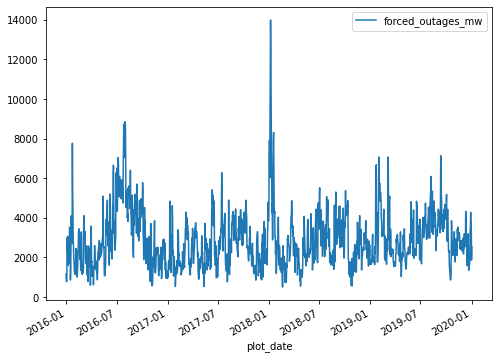

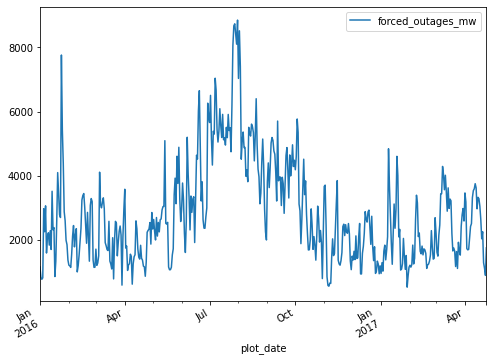

In [ ]:
plot_cols = [f'{target_feature}']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Clean up and High Level Statistics

In [ ]:
df = df.select_dtypes(include='float64')
df

,forced_outages_mw,Usage_mw,PRCP,TMAX,TMIN,SNOW,SNWD
0,1159.0,899146.903,0.002222,47.644444,34.200000,0.010526,0.000000
1,842.0,942882.797,0.000000,39.878049,27.744186,0.000000,0.000000
2,774.0,947082.331,0.000000,43.022222,25.600000,0.000000,0.000000
3,819.0,1130978.206,0.005106,42.595745,23.085106,0.105263,0.052632
4,2974.0,1269061.592,0.010213,29.212766,10.914894,0.036842,0.052632
...,...,...,...,...,...,...,...
1455,4274.0,916089.631,0.073023,56.860465,34.302326,0.000000,0.000000
1456,2922.0,943757.918,0.392558,54.209302,41.255814,0.000000,0.000000
1457,3717.0,951694.034,0.106512,54.581395,36.534884,0.000000,0.000000
1458,1863.0,955476.788,0.019524,46.000000,32.511628,0.133333,0.095238


Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
forced_outages_mw,1460.0,2.849552e+03,1410.795917,502.000000,1869.000000,2577.500000,3.585000e+03,1.398900e+04
Usage_mw,1460.0,1.021781e+06,156338.686870,732432.630000,895838.943500,993047.201500,1.123968e+06,1.508397e+06
PRCP,1460.0,1.357318e-01,0.213569,0.000000,0.004255,0.040233,1.682898e-01,1.701163e+00
TMAX,1460.0,6.414948e+01,17.877631,14.604651,48.705556,66.044995,8.033721e+01,9.427660e+01
TMIN,1460.0,4.403462e+01,16.609171,-2.279070,30.483688,44.177466,5.921922e+01,7.341860e+01
SNOW,1460.0,8.610852e-02,0.414148,0.000000,0.000000,0.000000,0.000000e+00,8.500000e+00
SNWD,1460.0,2.449372e-01,0.942696,0.000000,0.000000,0.000000,2.500000e-02,1.669231e+01


#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
#timestamp_s = date_time.map(datetime.datetime.timestamp)
#timestamp_s

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

## Seasonality



## Add Seasonality as a Feature for Models



In [ ]:
assert len(df) == 365 * 4

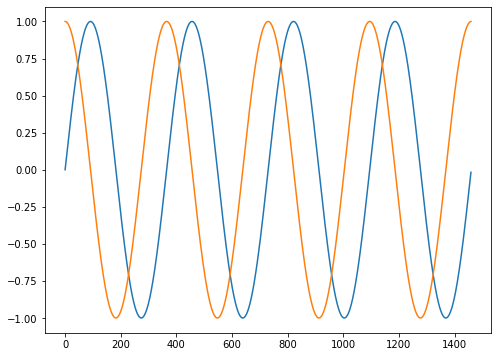

In [ ]:
#365 *4
if seasonal:
    df['sin'] = np.arange(365*4) * (2*np.pi/365)
    df['sin'] = np.sin(df['sin'])
    df['cos'] = np.arange(365*4) * (2*np.pi/365)
    df['cos'] = np.cos(df['cos'])

    plt.plot(df['sin'])
    plt.plot(df['cos'])
    plt.plot()
else:
    print('The dataframe does not contain sin and cos to add seasonality.')

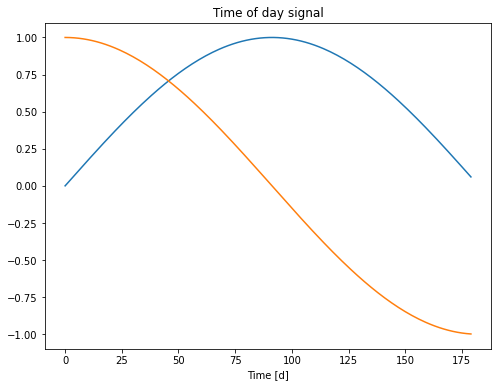

In [ ]:
if seasonal:
    plt.plot(np.array(df['sin'])[:180])
    plt.plot(np.array(df['cos'])[:180])
    plt.xlabel('Time [d]')
    plt.title('Time of day signal')

else:
    print('Nothing to plot. The dataframe does not contain sin and cos seasonality features.')

In [ ]:
df

,forced_outages_mw,Usage_mw,PRCP,TMAX,TMIN,SNOW,SNWD,sin,cos
0,1159.0,899146.903,0.002222,47.644444,34.200000,0.010526,0.000000,0.000000,1.000000
1,842.0,942882.797,0.000000,39.878049,27.744186,0.000000,0.000000,0.017213,0.999852
2,774.0,947082.331,0.000000,43.022222,25.600000,0.000000,0.000000,0.034422,0.999407
3,819.0,1130978.206,0.005106,42.595745,23.085106,0.105263,0.052632,0.051620,0.998667
4,2974.0,1269061.592,0.010213,29.212766,10.914894,0.036842,0.052632,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...
1455,4274.0,916089.631,0.073023,56.860465,34.302326,0.000000,0.000000,-0.085965,0.996298
1456,2922.0,943757.918,0.392558,54.209302,41.255814,0.000000,0.000000,-0.068802,0.997630
1457,3717.0,951694.034,0.106512,54.581395,36.534884,0.000000,0.000000,-0.051620,0.998667
1458,1863.0,955476.788,0.019524,46.000000,32.511628,0.133333,0.095238,-0.034422,0.999407


### Split Data for Model Testing

We are using a `(70%, 20%, 10%)` split for the training, validation, and test sets as recommended by the Tensor Flow tutorial. It is important to notice that the this spliting of data is not randomly shuffling the data before spliting because:

Below are the reasonings given by the tutorial and we also think these reasons are important.
1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_df.dtypes

forced_outages_mw    float64
Usage_mw             float64
PRCP                 float64
TMAX                 float64
TMIN                 float64
SNOW                 float64
SNWD                 float64
sin                  float64
cos                  float64
dtype: object

### Normalize the data

Scale features before training models. We normalize the data by subtract the mean and dividing by the standard deviation of each feature.

In [ ]:
train_df

,forced_outages_mw,Usage_mw,PRCP,TMAX,TMIN,SNOW,SNWD,sin,cos
0,1159.0,899146.903,0.002222,47.644444,34.200000,0.010526,0.000000,0.000000,1.000000
1,842.0,942882.797,0.000000,39.878049,27.744186,0.000000,0.000000,0.017213,0.999852
2,774.0,947082.331,0.000000,43.022222,25.600000,0.000000,0.000000,0.034422,0.999407
3,819.0,1130978.206,0.005106,42.595745,23.085106,0.105263,0.052632,0.051620,0.998667
4,2974.0,1269061.592,0.010213,29.212766,10.914894,0.036842,0.052632,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...
1016,1339.0,864482.578,0.118298,68.651163,47.348837,0.000000,0.000000,-0.977848,0.209315
1017,1147.0,869952.133,0.089348,60.288889,44.244444,0.000000,0.000000,-0.974100,0.226116
1018,1377.0,878226.835,0.005217,60.488889,38.844444,0.000000,0.000000,-0.970064,0.242850
1019,1011.0,887708.163,0.000000,55.755556,34.088889,0.000000,0.000000,-0.965740,0.259512


In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Below there are some features such as:



*   Forced_outages_mw
*   PRCP
*   SNOW
*   SNWD

We will keep this in mind when we proceed with model testing because linear regression maybe sensitive to the outliers





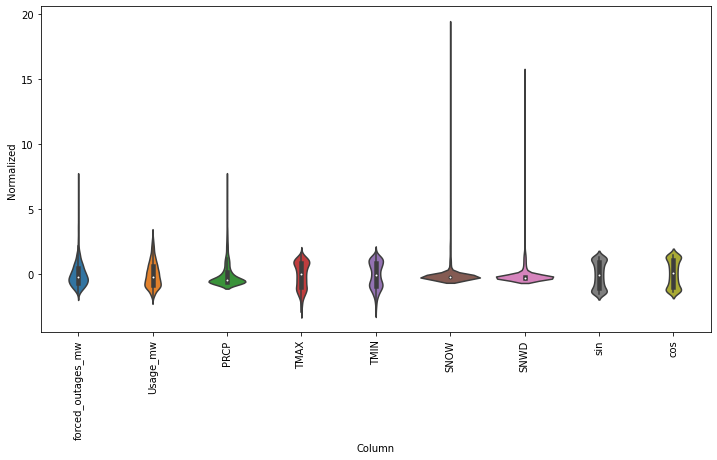

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## This section is taken from Tensor Flow's documentation to give background about Data Windowing and how it works.

#### Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

#### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[f'{target_feature}'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['forced_outages_mw']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[f'{target_feature}'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['forced_outages_mw']

#### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 2, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['forced_mw_outages']`. Initially this tutorial will build models that predict single output labels.

#### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col=target_feature, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

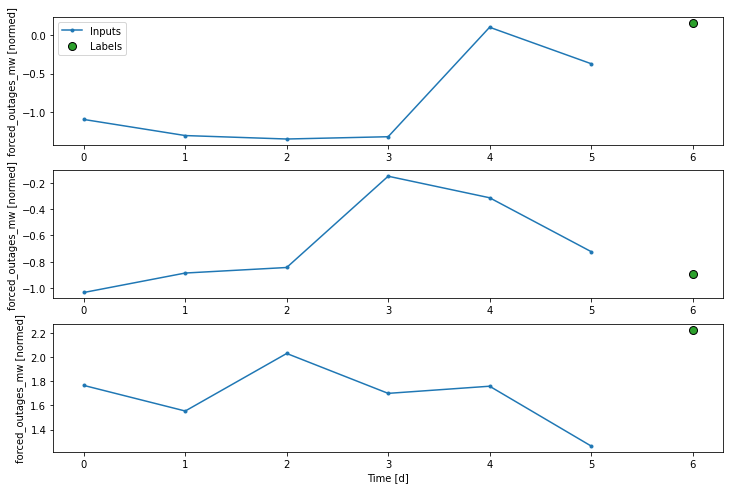

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `forced_outages_mw` column.

#### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `forced_outages_mw` value 1h into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[f'{target_feature}'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['forced_outages_mw']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.



In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices[target_feature])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.2897 - mean_absolute_error: 0.3679


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

### **Wide Window Size Definition**

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[target_feature])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['forced_outages_mw']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

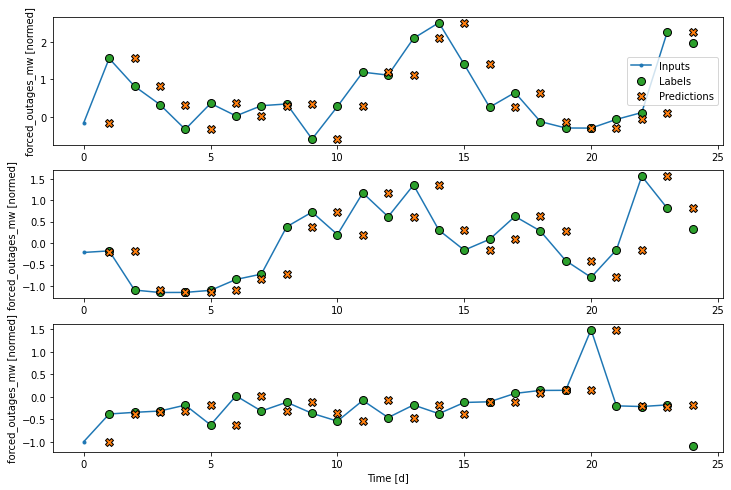

In [ ]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explaination:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Compile and Fit Model

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2,model_name='anything'):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  if model_name == 'linear':
      model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.SGD(),metrics=[tf.metrics.MeanAbsoluteError()])
  else:
      model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.RMSprop(),metrics=[tf.metrics.MeanAbsoluteError()]) 

    

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

Train the model and evaluate its performance:

In [ ]:
history = compile_and_fit(linear, single_step_window,model_name='linear')

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
32/32 [==============================] - 0s 9ms/step - loss: 1.8366 - mean_absolute_error: 1.0140 - val_loss: 0.4870 - val_mean_absolute_error: 0.5305
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 0.5034 - mean_absolute_error: 0.5251 - val_loss: 0.3152 - val_mean_absolute_error: 0.4102
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.3422 - mean_absolute_error: 0.4298 - val_loss: 0.2770 - val_mean_absolute_error: 0.3762
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.3045 - mean_absolute_error: 0.4055 - val_loss: 0.2673 - val_mean_absolute_error: 0.3675
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2911 - mean_absolute_error: 0.3968 - val_loss: 0.2612 - val_mean_absolute_error: 0.3616
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2836 - mean_absolute_error: 0.3919 - val_loss: 0.2604 - val_mean_absolute_error: 0.3616
Epoch 7/20
32/32 [==========

In [ ]:
history.model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1, 1)              10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [ ]:
linear_opt = str(history.model.optimizer)

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecuitive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the precictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_widow`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

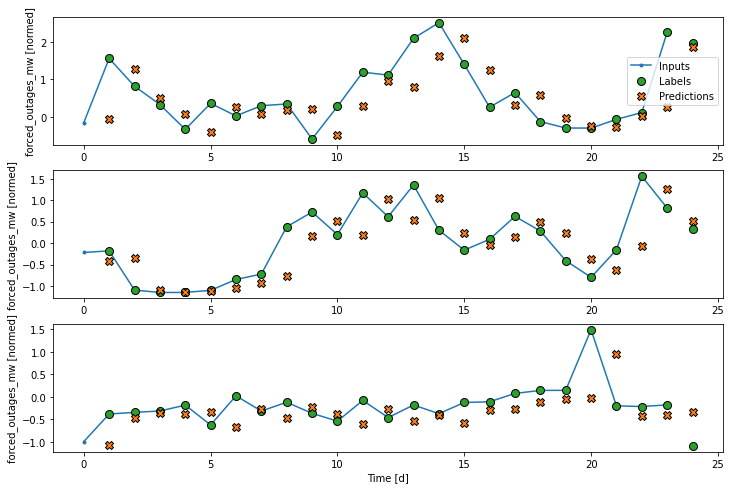

In [ ]:
wide_window.plot(linear)

Pull layer weights out of linear model

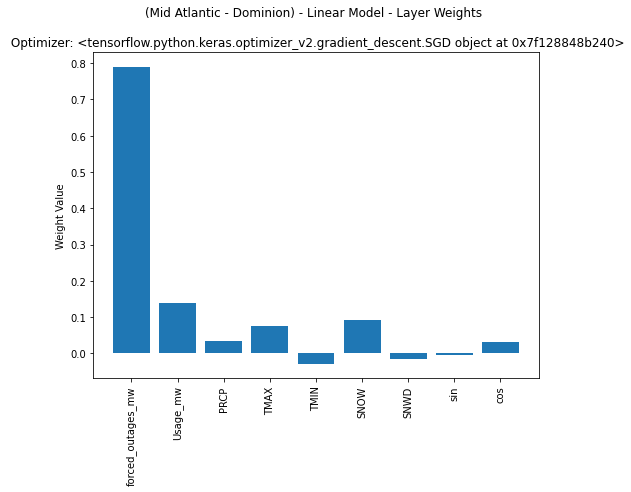

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())

if seasonal:
    plt.title(f'({region}) - Linear Model - Layer Weights \n\n Optimizer: {history.model.optimizer}')
else:
     plt.title(f'({region}) - Linear Model - Layer Weights - \n\n Optimizer: {history.model.optimizer}')


plt.ylabel('Weight Value')
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `forced_outages_mw`. This is one of the risks of random initialization. 

### Dense

This model is similar to the `linear` model, excep there are two `Dense` layers between the input and the output: 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5113 - mean_absolute_error: 0.5010 - val_loss: 0.2610 - val_mean_absolute_error: 0.3657
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2964 - mean_absolute_error: 0.4020 - val_loss: 0.2552 - val_mean_absolute_error: 0.3598
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.2702 - mean_absolute_error: 0.3895 - val_loss: 0.2672 - val_mean_absolute_error: 0.3639
Epoch 4/20
10/10 [==============================] - 0s 2ms/step - loss: 0.2643 - mean_absolute_error: 0.3649


In [ ]:
history.model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1, 64)             640       
_________________________________________________________________
dense_12 (Dense)             (None, 1, 64)             4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1, 1)              65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.



In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[target_feature])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['forced_outages_mw']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

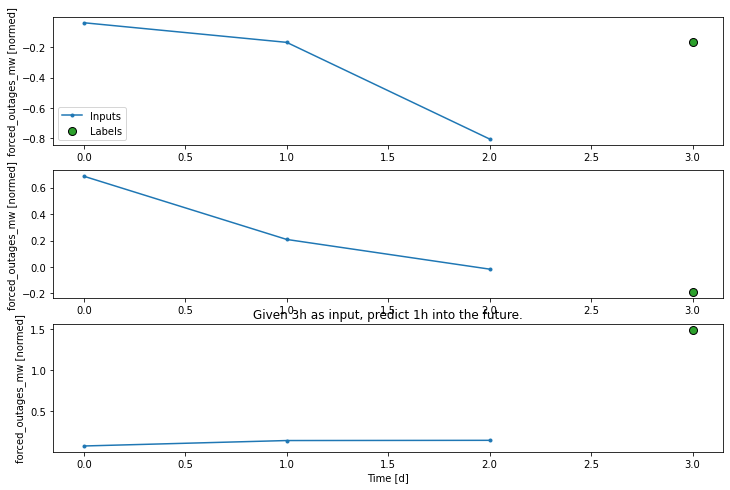

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.2931 - mean_absolute_error: 0.3965


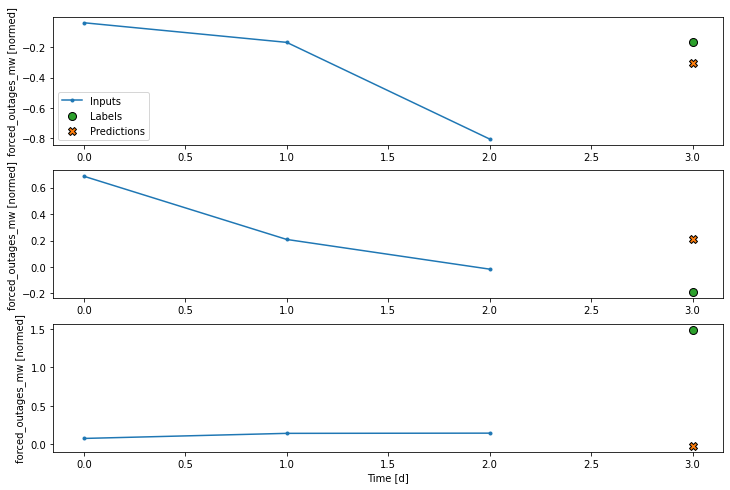

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
history.model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 27)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                896       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1)              0         
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 9)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,216], In[1]: [27,32] [Op:MatMul]


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.2894 - mean_absolute_error: 0.3918


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[target_feature])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['forced_outages_mw']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

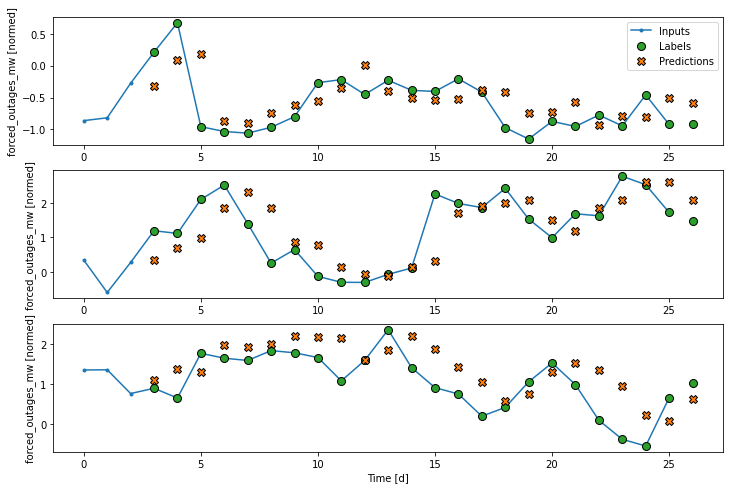

In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
history.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          896       
_________________________________________________________________
dense_17 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dense_18 (Dense)             (None, None, 1)           33        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

9/9 [==============================] - 0s 4ms/step - loss: 0.2832 - mean_absolute_error: 0.3734


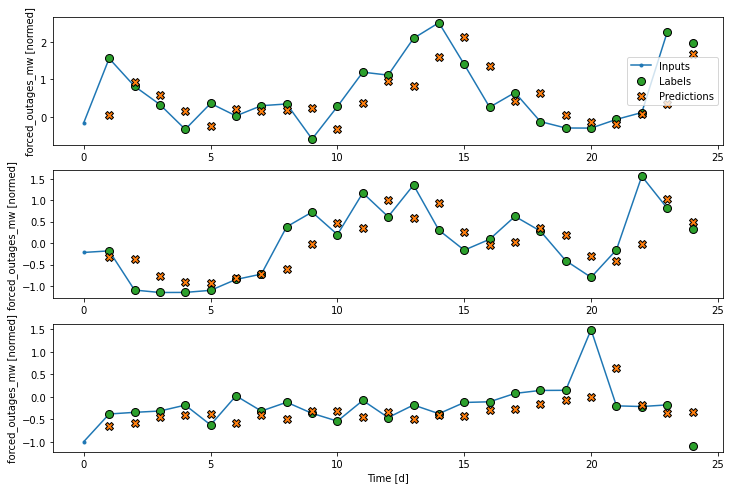

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
history.model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 32)            5376      
_________________________________________________________________
dense_19 (Dense)             (None, 24, 1)             33        
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


### Performance

With this dataset typically each of the models does slightly better than the one before it.

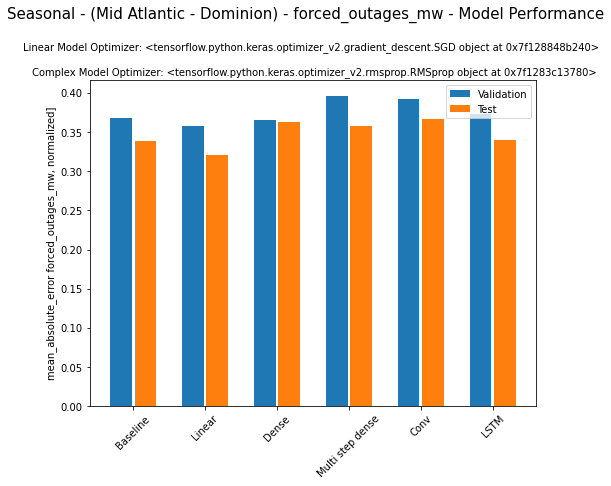

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

if seasonal:
    plt.suptitle(f'Seasonal - ({region}) - {target_feature} - Model Performance',fontsize=15, y=1.05)
    plt.title(f'\nLinear Model Optimizer: {linear_opt} \n\n Complex Model Optimizer: {history.model.optimizer}',fontsize=10)



else:
    plt.title(f'({region}) - {target_feature} - Model Performance')

plt.ylabel(f'mean_absolute_error {target_feature}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.3387
Linear      : 0.3210
Dense       : 0.3635
Multi step dense: 0.3584
Conv        : 0.3668
LSTM        : 0.3404
